In [1]:
using Pkg
Pkg.activate("..")

 Activating environment at `~/Documents/Catlab/AlgebraicDynamics.jl/Project.toml`


In [2]:
using AlgebraicDynamics

using Catlab
using Catlab.CategoricalAlgebra
using Catlab.CategoricalAlgebra.CSets
using Catlab.WiringDiagrams
using Catlab.Graphics
using Catlab.Graphics.Graphviz
using Catlab.Graphs

using DifferentialEquations

using Plots

┌ Info: Precompiling AlgebraicDynamics [5fd6ff03-a254-427e-8840-ba658f502e32]
└ @ Base loading.jl:1260


# Implementing Resources Sharing Machines

In this notebook, we describe the process of composing dynamical systems as (1) resource sharers, (2) machines, and (3) resource sharing machines.

These features are implemented more complicated-ly in the AlgebraicDynamics.jl package. In this notebook we implement "baby" versions for the sake of clarity.

## A Theory of Machines

We define a machine to be a system which takes input, updates its internal state, and exposes some output. The schema for machines is:

<img src="images/Theory of Machines.png" alt="schema for theory of machines" style="width: 600px;"/>

Note that this composition pattern is a special case of an operation in the operad of wiring diagrams of finite sets where the codomain is the unit.

In [3]:
@present TheoryMachines(FreeSchema) begin        
    Value::Data
    Dynamics::Data

    Box::Ob
    InPort::Ob
    OutPort::Ob
    StateVariable::Ob

    parameterizes::Hom(InPort, Box)
    state::Hom(OutPort, StateVariable)
    system::Hom(StateVariable, Box)
    feeder::Hom(InPort, OutPort)
    
    value::Attr(StateVariable, Value)
    dynamics::Attr(Box, Dynamics)
end

const AbstractMachine = AbstractACSetType(TheoryMachines)
const Machine = ACSetType(TheoryMachines, index=[:parameterizes, :state, :system, :value, :feeder, :dynamics])
Machine() = Machine{Real, Function}()

Catlab.CSetDataStructures.AttributedCSet{Catlab.Theories.CatDesc{(:Box, :InPort, :OutPort, :StateVariable),(:parameterizes, :state, :system, :feeder),(2, 3, 4, 2),(1, 4, 1, 3)},Catlab.Theories.AttrDesc{Catlab.Theories.CatDesc{(:Box, :InPort, :OutPort, :StateVariable),(:parameterizes, :state, :system, :feeder),(2, 3, 4, 2),(1, 4, 1, 3)},(:Value, :Dynamics),(:value, :dynamics),(4, 1),(1, 2)},Tuple{Value,Dynamics},(:dynamics, :feeder, :parameterizes, :state, :system, :value),(),Tables,Indices} where Indices<:NamedTuple where Tables<:NamedTuple where Dynamics where Value

In [46]:
# Turn a Machine into an ODE problem

function vectorfield(m::AbstractMachine)
    function f(u, p, t)
        newstate = zero(u)
        for b in parts(m, :Box)
            ivalues = view(u,  subpart(m, incident(m, b, :parameterizes), :feeder))
            states = incident(m, b, :system)
            dynamics = subpart(m, b, :dynamics)
            view(newstate, states) .= dynamics(view(u, states), ivalues)
        end
        return newstate
    end
end

vectorfield (generic function with 1 method)

## Lokta-Volterra as machines

A parameterized ODE modeling a rabbit population takes as input a population of predators $\mathsf{pred}$ and evolves according to $$\dot r(\mathsf{pred})\alpha r - \beta r(\mathsf{pred})$$.

Similarly a ODE modeling a fox population takes as input a population of prey $\mathsf{prey}$ and evolves according to $$\dot f(\mathsf{prey}) = -\gamma f + \delta  f(\mathsf{prey}).$$

In [45]:
# parameters and initial condition chosen to match the example in 
#      https://algebraicjulia.github.io/AlgebraicPetri.jl/dev/examples/predation/lotka-volterra/
α = .3
β = .015
γ = .7
δ = β

u0 = [10.0, 100.0]

dotr = (r,pred) -> [α*r[1] - β*r[1]*pred[1]]
dotf = (f,prey) -> [δ*f[1]*prey[1] - γ*f[1]]

lv = Machine()
add_parts!(lv, :Box,    2, dynamics = [dotr, dotf])
add_parts!(lv, :StateVariable,  2, system = [1,2], value=u0)
add_parts!(lv, :OutPort,2, state = [1,2])
add_parts!(lv, :InPort, 2, parameterizes = [1,2], feeder = [2,1])

lv

ACSet with elements Box = 1:2, InPort = 1:2, OutPort = 1:2, StateVariable = 1:2
┌─────┬──────────┐
│ Box │ dynamics │
├─────┼──────────┤
│   1 │      #48 │
│   2 │      #50 │
└─────┴──────────┘
┌────────┬───────────────┬────────┐
│ InPort │ parameterizes │ feeder │
├────────┼───────────────┼────────┤
│      1 │             1 │      2 │
│      2 │             2 │      1 │
└────────┴───────────────┴────────┘
┌─────────┬───────┐
│ OutPort │ state │
├─────────┼───────┤
│       1 │     1 │
│       2 │     2 │
└─────────┴───────┘
┌───────────────┬────────┬───────┐
│ StateVariable │ system │ value │
├───────────────┼────────┼───────┤
│             1 │      1 │  10.0 │
│             2 │      2 │ 100.0 │
└───────────────┴────────┴───────┘

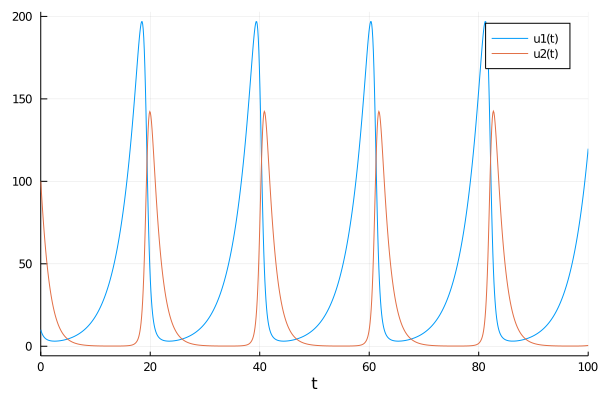

In [47]:
prob = ODEProblem(vectorfield(lv), u0, (0.0, 100.0))
sol = solve(prob)
plot(sol)

## Modularity of Machines

One of the great things about compositional dynamics is that you can build your models modularly.

For example consider an ecosystem composed of little fish, big fish, and sharks where the big fish are predators to the little fish and prey to the sharks. To construct the ODE corresponding to this model, you might get lost trying to keep all of your variables straight. However, as a composition of machines, it is much more straightforward.

In [56]:
α = .3
β = .015
γ = .7
δ = β
β′ = .017
γ′ = .35
δ′ = β′

u0 = [100.0, 10.0, 2.0]

dotfish(f, x) = [α*f[1] - β*x[1]*f[1]]
dotFISH(F, x) = [δ*x[1]*F[1] - γ*F[1] - β′*x[2]*F[1]]    # x[1] - prey, x[2] - predator
dotsharks(s, x) = [-γ′*s[1] + δ′*s[1]*x[1]]

lv3 = Machine()
add_parts!(lv3, :Box,    3, dynamics = [dotfish, dotFISH, dotsharks])
add_parts!(lv3, :StateVariable,  3, system = [1,2,3], value=u0)
add_parts!(lv3, :OutPort,3, state = [1,2,3])
add_parts!(lv3, :InPort, 4, parameterizes = [1,2,2,3], feeder = [2,1,3,2])

lv3

ACSet with elements Box = 1:3, InPort = 1:4, OutPort = 1:3, StateVariable = 1:3
┌─────┬───────────┐
│ Box │  dynamics │
├─────┼───────────┤
│   1 │   dotfish │
│   2 │   dotFISH │
│   3 │ dotsharks │
└─────┴───────────┘
┌────────┬───────────────┬────────┐
│ InPort │ parameterizes │ feeder │
├────────┼───────────────┼────────┤
│      1 │             1 │      2 │
│      2 │             2 │      1 │
│      3 │             2 │      3 │
│      4 │             3 │      2 │
└────────┴───────────────┴────────┘
┌─────────┬───────┐
│ OutPort │ state │
├─────────┼───────┤
│       1 │     1 │
│       2 │     2 │
│       3 │     3 │
└─────────┴───────┘
┌───────────────┬────────┬───────┐
│ StateVariable │ system │ value │
├───────────────┼────────┼───────┤
│             1 │      1 │ 100.0 │
│             2 │      2 │  10.0 │
│             3 │      3 │   2.0 │
└───────────────┴────────┴───────┘

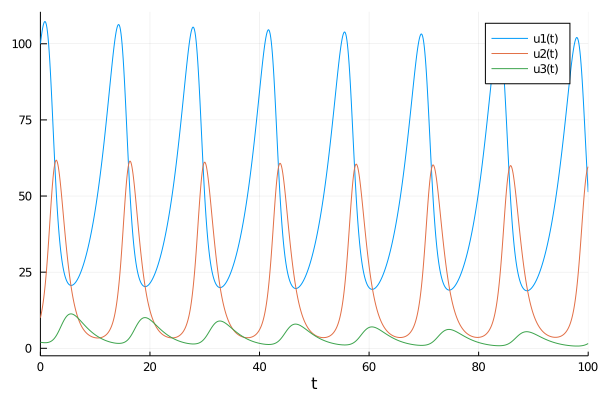

In [58]:
prob = ODEProblem(vectorfield(lv3), u0, (0.0, 100.0))
sol = solve(prob)
plot(sol)

## Appendix

In [184]:
# Discrete update function

function update!(y::AbstractVector, f::Function, x::AbstractVector, args...)
    y .= f(x, args...)
end

function update!(newstate::AbstractVector, dm::AbstractMachine, state::AbstractVector) 
    
    for b in parts(dm, :Box)
        ivalues = view(state,  subpart(dm, incident(dm, b, :parameterizes), :feeder))
        states = incident(dm, b, :system)
        dynamics = subpart(dm, b, :dynamics)
        newvalues = update!(view(newstate, states),
                            dynamics, 
                            view(state, states), 
                            ivalues)
    end
    
    return newstate
end

update! (generic function with 4 methods)

In [ ]:
α = 1.2
β = 0.1
γ = 1.3
δ = 0.1

dotr = (r,i) -> [α*r[1] - β*i[1]*r[1]]
dotf = (f,j) -> [-γ*f[1] + δ* j[1]* f[1]]

function eulers(f::Function, h::Float64) 
    return (x0, args...) -> x0 .+ h*f(x0, args...)
end

function approx(f::Function, h::Float64)
    return (x0, args...) -> solve(ODEProblem((x,p,t) -> f(x0, args...), x0, (0, h)), 
                                    save_everystep = false, save_start=false,save_end = true)[1]
end

h = 0.1

lv = Machine()
add_parts!(lv, :Box,    2, dynamics = [eulers(dotr,h), eulers(dotf,h)])
add_parts!(lv, :StateVariable,  2, system = [1,2], value=[17, 11])
add_parts!(lv, :OutPort,2, state = [1,2])
add_parts!(lv, :InPort, 2, parameterizes = [1,2], feeder = [2,1])

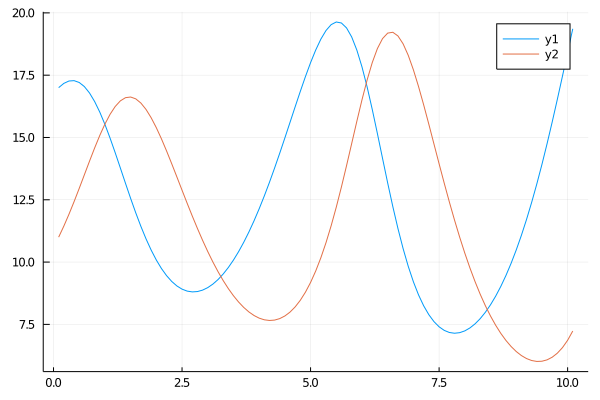

In [198]:
N = 100
k = nparts(lv, :StateVariable)

xs = Array{Float64}(undef, N + 1, k)
xs[1, : ] = subpart(lv, :value)

for i in 1:N
    update!(view(xs,i+1, 1:k), lv, view(xs, i, 1:k))
end

ts = map(t -> t*h, 1:N+1)
rs = xs[:, 1]
fs = xs[:, 2]

plot(ts, rs)
plot!(ts, fs)